In [1]:
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, Input, Lambda, LSTM

c:\Users\HP\anaconda3\envs\tf\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("../datasets/consolidated_data/oil_data.csv", index_col="DATEPRD")

date = df.index
df.head()

,BORE_OIL_VOL
DATEPRD,
2008-02-12,284.65
2008-02-13,1869.70
2008-02-14,3124.09
2008-02-15,2608.28
2008-02-16,3051.80


In [3]:
#function to plot a series
def plot_series(x, y, type_=None, ylabel=None, format="-", start=None, end=None, label=None, multi_plot=True):
    if not multi_plot:
        plt.figure(figsize=(20, 10))
    plt.plot(x[start:end], y[start:end], format, label=label)
    plt.xlabel("Date", labelpad=50, fontsize=14)
    plt.ylabel(f"{ylabel} Volume", labelpad=50, fontsize=14)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True, which='both')
    x_ticks = x.to_list()
    x_max = max(x_ticks)
    x_ticks = x_ticks[::round(len(x_ticks)/10)]
    x_ticks.append(x_max)
    plt.xticks(x_ticks, rotation = 30)
    if not multi_plot:
        plt.savefig(f'../plots/{ylabel.lower()}/{ylabel.lower()}_{type_}_time_series.png')
        plt.show()


#clear session 
def refresh():
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

class ResetStatesCallback(Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

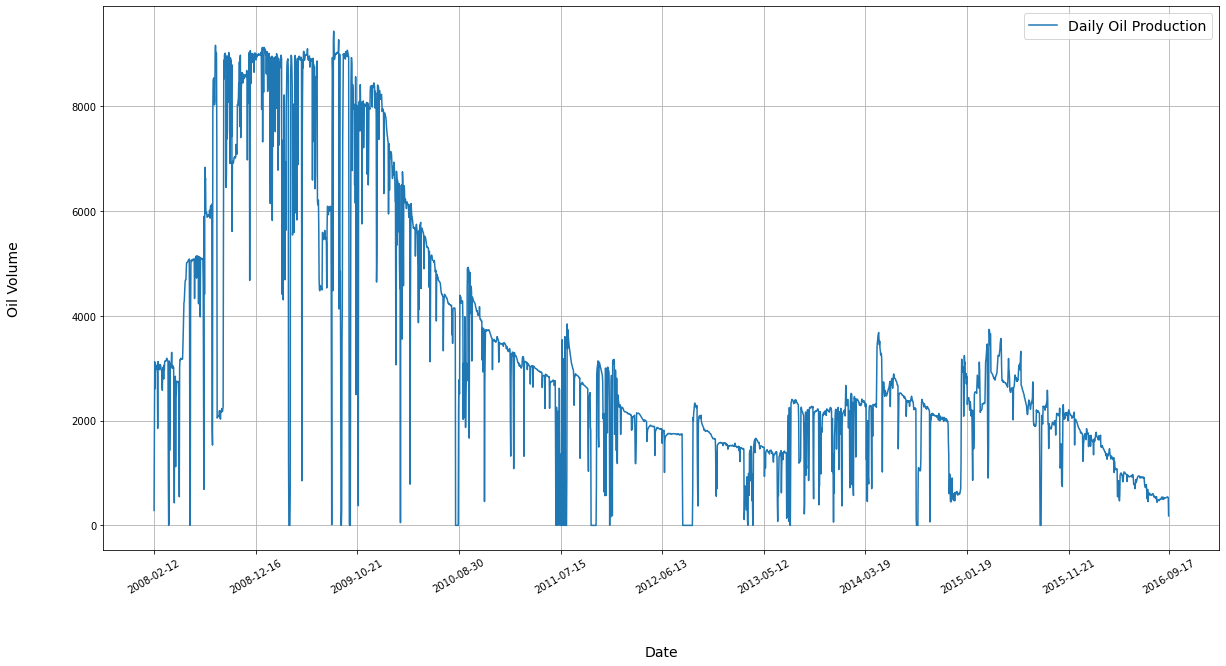

array([ 284.65, 1869.7 , 3124.09, ...,  534.87,  530.27,  180.04])

In [7]:
oil_data = df.BORE_OIL_VOL.to_numpy()
plot_series(date, oil_data, "unscaled", "Oil", label="Daily Oil Production", multi_plot=False)
oil_data

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)
scaled_df.head()

,BORE_OIL_VOL
DATEPRD,
2008-02-12,0.030164
2008-02-13,0.198133
2008-02-14,0.331061
2008-02-15,0.276400
2008-02-16,0.323400


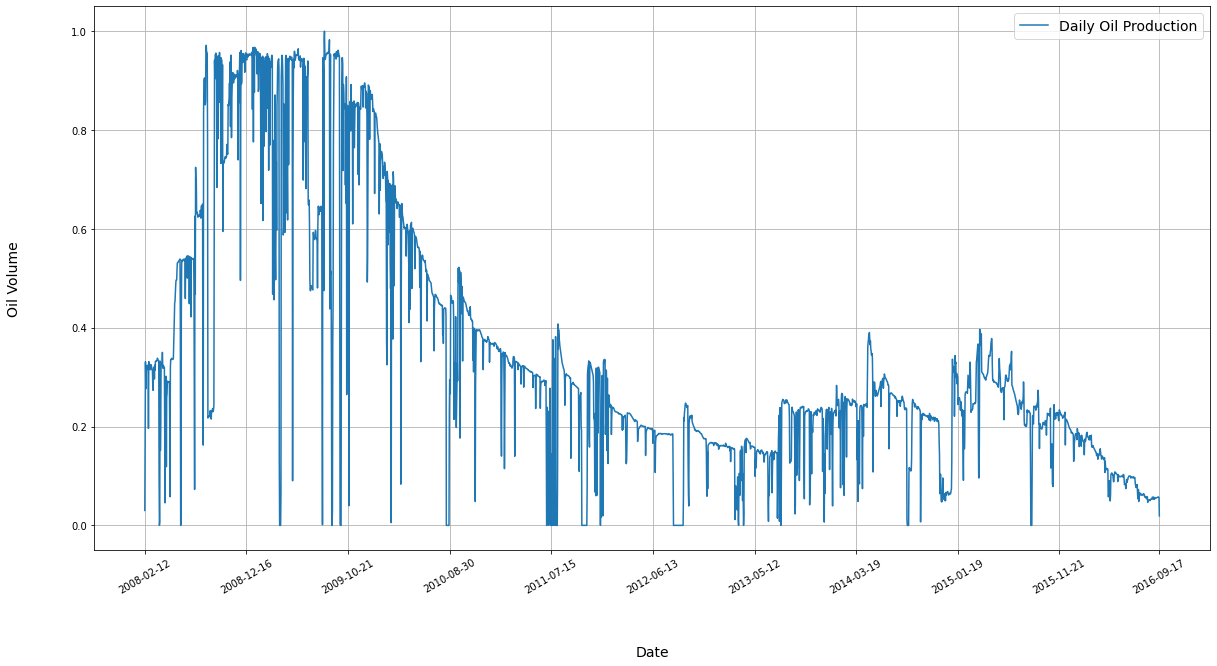

array([0.03016443, 0.19813259, 0.33106062, ..., 0.05668031, 0.05619285,
       0.01907889])

In [6]:
scaled_oil_data = scaled_df.BORE_OIL_VOL.to_numpy()
plot_series(date, scaled_oil_data, "scaled", "Oil", label="Daily Oil Production", multi_plot=False)

scaled_oil_data

In [8]:
#split the time series into training and validation sets
split_date = 2140

date_train = date[:split_date]
oil_train = scaled_oil_data[:split_date]

date_valid = date[split_date:]
oil_valid = scaled_oil_data[split_date:]

print(date_train.shape, oil_train.shape, date_valid.shape, oil_valid.shape)

(2140,) (2140,) (916,) (916,)


# NAIVE Forecast

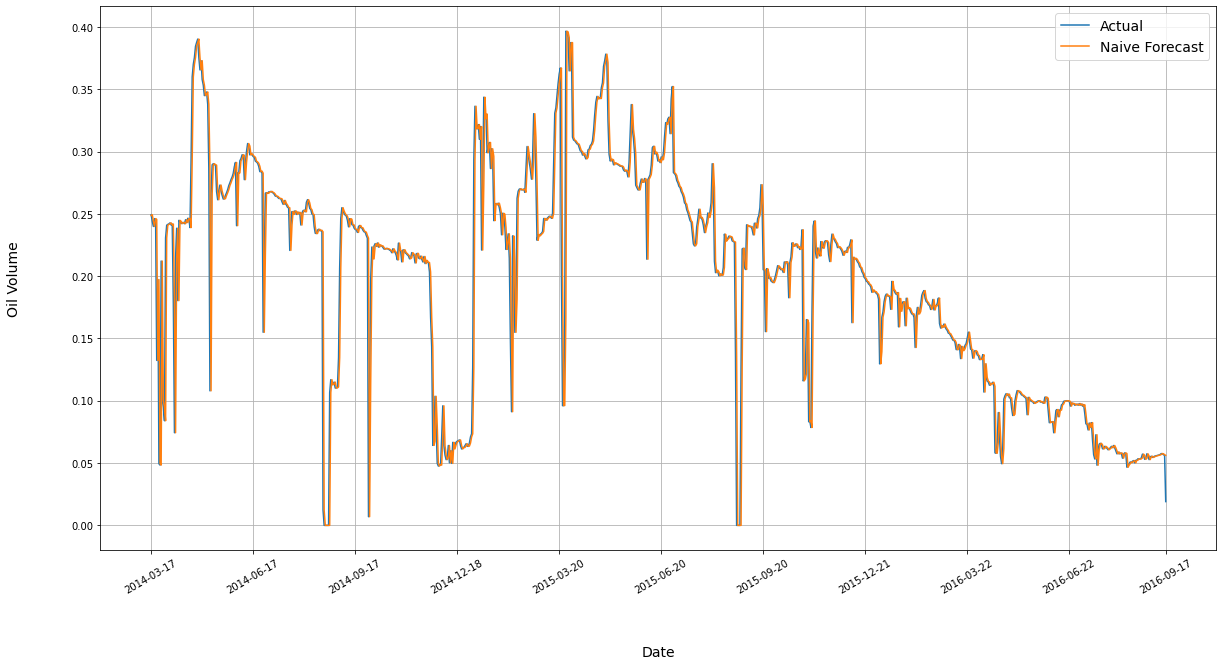

mae = 0.01122068857447045, 
mse = 0.0008306426000780922, 
rmse = 0.02882087091116596


In [28]:
naive_oil_forecast = scaled_oil_data[split_date - 1:-1]

plt.figure(figsize=(20, 10))

plot_series(date_valid, oil_valid, ylabel="Oil", label="Actual")
plot_series(date_valid, naive_oil_forecast, ylabel="Oil", label="Naive Forecast")

plt.savefig(f'../plots/oil/oil_naive_forecast.png')
plt.show()

mae = keras.metrics.mean_absolute_error(oil_valid, naive_oil_forecast).numpy()
mse = keras.metrics.mean_squared_error(oil_valid, naive_oil_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

# Moving Average

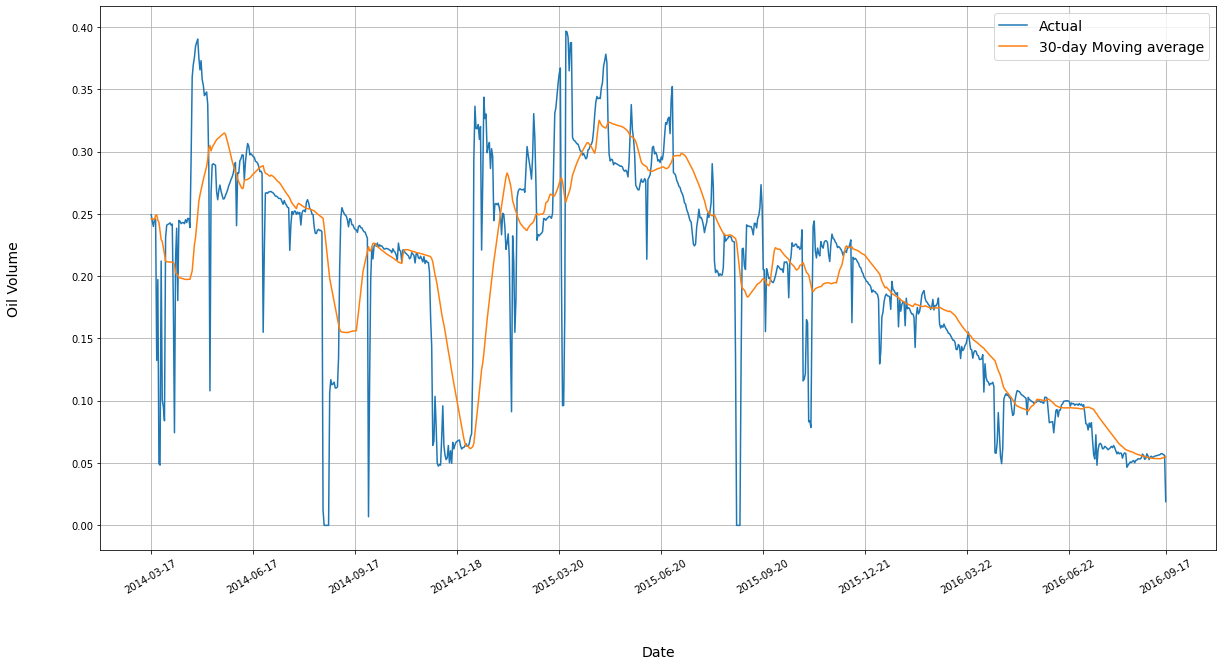

mae = 0.03273613551274349, 
mse = 0.002995516502085705, 
rmse = 0.054731311898087234


In [29]:
# Moving Average

def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
    If window_size=1, then this is equivalent to naive forecast"""
    
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    
    return mov[window_size - 1:-1] / window_size

oil_moving_avg = moving_average_forecast(scaled_oil_data, 30)[split_date - 30:]

plt.figure(figsize=(20, 10))

plot_series(date_valid, oil_valid, ylabel="Oil", label="Actual")
plot_series(date_valid, oil_moving_avg, ylabel="Oil", label="30-day Moving average")

plt.savefig(f'../plots/oil/oil_30d_mov_avg_forecast.png')
plt.show()

mae = keras.metrics.mean_absolute_error(oil_valid, oil_moving_avg).numpy()
mse = keras.metrics.mean_squared_error(oil_valid, oil_moving_avg).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

# Linear Model

In [22]:
def window_dataset(series, window_size, batch_size=30, shuffle_buffer=100):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(2)
    
    return dataset


def model_forecast(model, series, window_size):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(30).prefetch(2)
    
    forecast = model.predict(dataset)
    
    return forecast

In [ ]:
refresh()

window_size = 30

oil_train_set = window_dataset(oil_train, window_size)

model = Sequential( [ Dense(1, input_shape=[window_size]) ] )

lr_schedule = LearningRateScheduler(
                lambda epoch: 1e-4 * 10**(epoch / 30)
                )

optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(oil_train_set, epochs=100, callbacks=[lr_schedule])

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([5e-5, 5e-1, 0, 0.3])

plt.show()

max(history.history["loss"])

In [23]:
keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

oil_train_set = window_dataset(oil_train, window_size)
oil_valid_set = window_dataset(oil_valid, window_size)

model = Sequential( [ Dense(1, input_shape=[window_size]) ] )

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(patience=10)

model.fit(
    
    oil_train_set,
    epochs=500,
    validation_data=oil_valid_set,
    callbacks=[early_stopping]

)

model.save('linear_oil_model.h5')

Epoch 1/500
71/71 [==============================] - 6s 26ms/step - loss: 0.1622 - mae: 0.4030 - val_loss: 0.0068 - val_mae: 0.0977
Epoch 2/500
71/71 [==============================] - 1s 15ms/step - loss: 0.0280 - mae: 0.1402 - val_loss: 0.0034 - val_mae: 0.0561
Epoch 3/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0270 - mae: 0.1411 - val_loss: 0.0033 - val_mae: 0.0554
Epoch 4/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0257 - mae: 0.1361 - val_loss: 0.0031 - val_mae: 0.0523
Epoch 5/500
71/71 [==============================] - 1s 13ms/step - loss: 0.0246 - mae: 0.1333 - val_loss: 0.0030 - val_mae: 0.0514
Epoch 6/500
71/71 [==============================] - 1s 11ms/step - loss: 0.0236 - mae: 0.1294 - val_loss: 0.0028 - val_mae: 0.0495
Epoch 7/500
71/71 [==============================] - 1s 13ms/step - loss: 0.0227 - mae: 0.1264 - val_loss: 0.0027 - val_mae: 0.0479
Epoch 8/500
71/71 [==============================] - 1s 13ms/step - loss: 0.

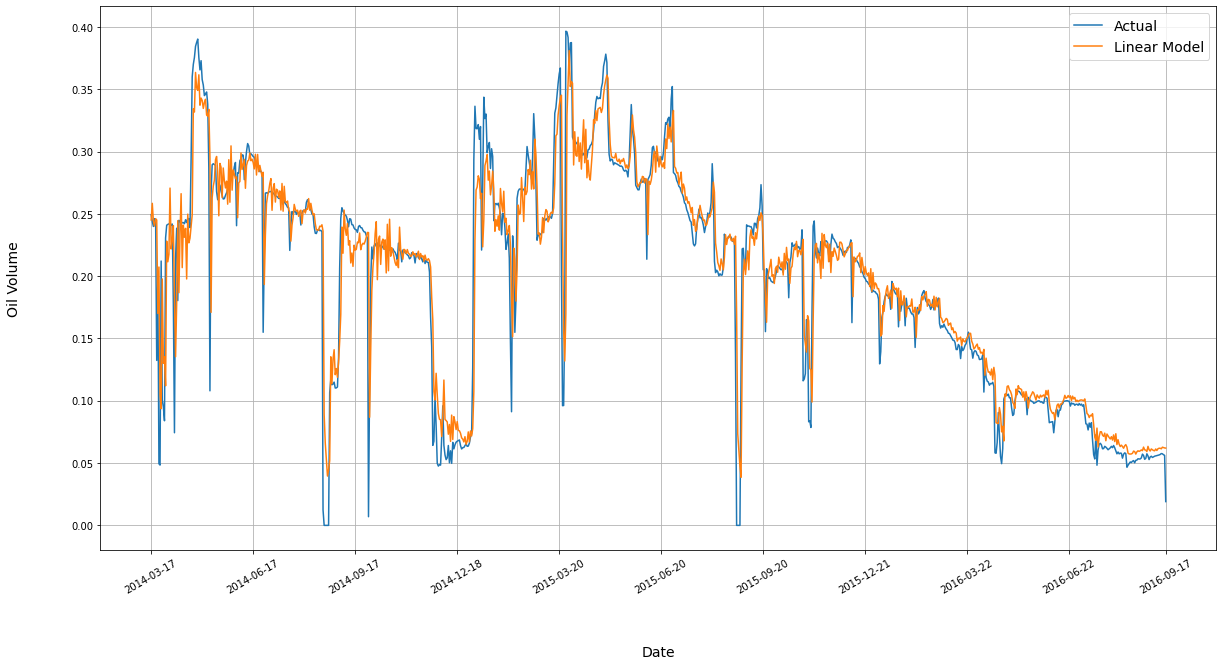

mae = 0.01636890321969986, 
mse = 0.0009179107728414237, 
rmse = 0.030297042311773995
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'dense/kernel:0' shape=(30, 1) dtype=float32, numpy=
array([[ 0.01023294],
       [ 0.03149624],
       [-0.08059137],
       [ 0.02751068],
       [ 0.01055475],
       [ 0.03290596],
       [ 0.02562249],
       [ 0.04276284],
       [-0.00134598],
       [-0.01908923],
       [ 0.08500396],
       [-0.15233009],
       [ 0.14138289],
       [-0.13368686],
       [ 0.11793065],
       [-0.03782655],
       [ 0.0205937 ],
       [ 0.00385739],
       [-0.05849741],
       [ 0.09042342],
       [-0.00590286],
       [-0.07701647],
       [ 0.160252

In [33]:
linear_oil_forecast = model_forecast(model, scaled_oil_data[split_date - window_size:-1], window_size)[:, 0]

plt.figure(figsize=(20, 10))

plot_series(date_valid, oil_valid, ylabel="Oil", label="Actual")
plot_series(date_valid, linear_oil_forecast, ylabel="Oil", label="Linear Model")

plt.savefig(f'../plots/oil/oil_linear_forecast.png')
plt.show()

mae = keras.metrics.mean_absolute_error(oil_valid, linear_oil_forecast).numpy()
mse = keras.metrics.mean_squared_error(oil_valid, linear_oil_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

model.summary()
print(model.trainable_variables)

#  FF-NN

In [ ]:
refresh()

window_size = 30

oil_train_set = window_dataset(oil_train, window_size)

model = Sequential([
            Dense(10, activation="relu", input_shape=[window_size]),
            Dense(10, activation="relu"),
            Dense(1)
        ])

lr_schedule = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(oil_train_set, epochs=100, callbacks=[lr_schedule])

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, 0.12])

plt.show()

max(history.history["lr"])

In [34]:
refresh()

window_size = 30

oil_train_set = window_dataset(oil_train, window_size)
oil_valid_set = window_dataset(oil_valid, window_size)

model = Sequential([
            Dense(10, activation="relu", input_shape=[window_size]),
            Dense(10, activation="relu"),
            Dense(1)
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(patience=10)

model.fit(oil_train_set,
          epochs=500,
          validation_data=oil_valid_set,
          callbacks=[early_stopping])

model.save('ffnn_oil_model.h5')

Epoch 1/500
71/71 [==============================] - 15s 46ms/step - loss: 0.0407 - mae: 0.2023 - val_loss: 0.0032 - val_mae: 0.0661
Epoch 2/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0114 - mae: 0.0952 - val_loss: 0.0020 - val_mae: 0.0435
Epoch 3/500
71/71 [==============================] - 1s 10ms/step - loss: 0.0116 - mae: 0.0990 - val_loss: 0.0019 - val_mae: 0.0433
Epoch 4/500
71/71 [==============================] - 1s 14ms/step - loss: 0.0110 - mae: 0.0944 - val_loss: 0.0018 - val_mae: 0.0409
Epoch 5/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0107 - mae: 0.0927 - val_loss: 0.0017 - val_mae: 0.0397
Epoch 6/500
71/71 [==============================] - 1s 10ms/step - loss: 0.0104 - mae: 0.0903 - val_loss: 0.0017 - val_mae: 0.0385
Epoch 7/500
71/71 [==============================] - 1s 15ms/step - loss: 0.0102 - mae: 0.0886 - val_loss: 0.0016 - val_mae: 0.0370
Epoch 8/500
71/71 [==============================] - 1s 9ms/step - loss: 0.0

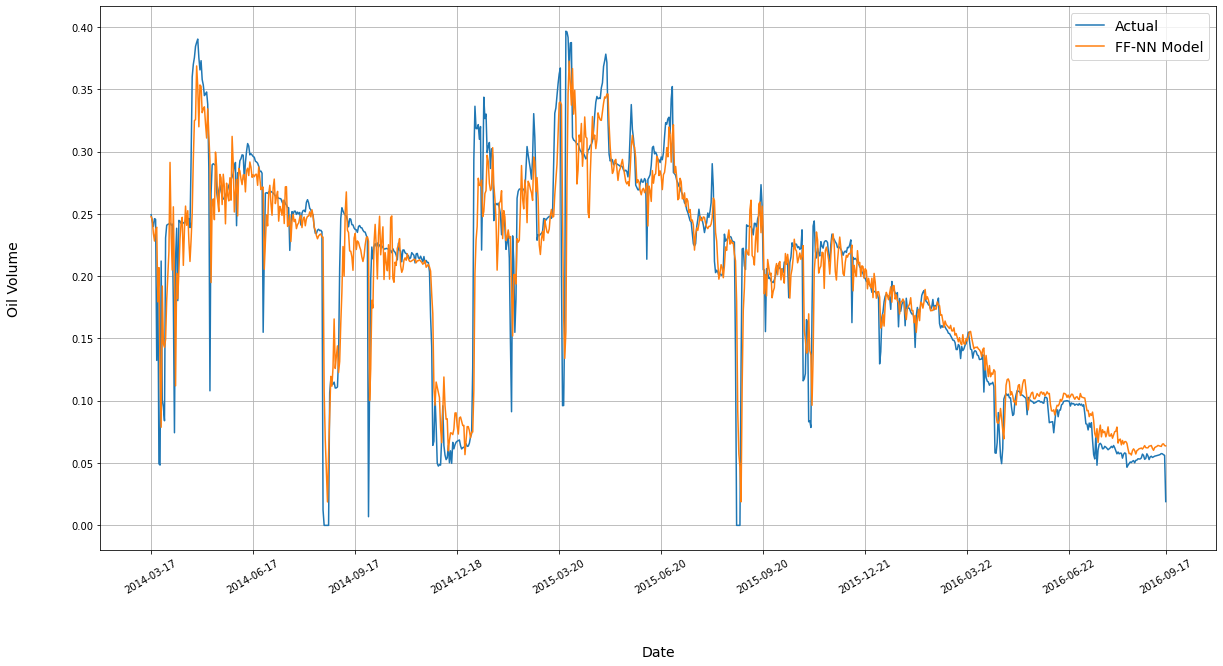

mae = 0.01900336891412735, 
mse = 0.0010764605831354856, 
rmse = 0.032809458744933385
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                310       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'dense/kernel:0' shape=(30, 10) dtype=float32, numpy=
array([[ 0.20595807,  0.11447667, -0.37471336, -0.13015972, -0.00883457,
        -0.05609543, -0.3234913 , -0.3707634 , -0.15478274, -0.0202557 ],
       [ 0.1331887 , -0.31488374,  0.33438036, -0.24735996,  0.1345936 ,
         0.040

In [36]:
ffnn_oil_forecast = model_forecast(
    
                    model,
                    scaled_oil_data[split_date - window_size:-1],
                    window_size

                                )[:, 0]

plt.figure(figsize=(20, 10))

plot_series(date_valid, oil_valid, ylabel="Oil", label="Actual")
plot_series(date_valid, ffnn_oil_forecast, ylabel="Oil", label="FF-NN Model")

plt.savefig(f'../plots/oil/oil_ffnn_forecast.png')
plt.show()

mae = keras.metrics.mean_absolute_error(oil_valid, ffnn_oil_forecast).numpy()
mse = keras.metrics.mean_squared_error(oil_valid, ffnn_oil_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

model.summary()
print(model.trainable_variables)

# RNN Model - LSTM

In [9]:
def sequential_window_dataset(series, window_size):
    
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[1:]))
    
    return dataset.batch(1).prefetch(1)

In [ ]:
refresh()

window_size = 30

oil_train_set = sequential_window_dataset(oil_train, window_size)

model = Sequential([
    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1)
    
        ])

learning_rate_schedule = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(oil_train_set, epochs=100, callbacks=[learning_rate_schedule, reset_states])

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 10, 0.009, 0.12])
plt.show()

max(history.history["lr"])

In [10]:
refresh()

window_size = 30
oil_train_set = sequential_window_dataset(oil_train, window_size)
oil_valid_set = sequential_window_dataset(oil_valid, window_size)

model = Sequential([
                    
        LSTM(10, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(10, return_sequences=True, stateful=True),
        Dense(1)
        
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

reset_states = ResetStatesCallback()
model_checkpoint = ModelCheckpoint("lstm/LSTM_oil_checkpoint.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=50)

history = model.fit(oil_train_set, epochs=500, validation_data=oil_valid_set, 
          callbacks=[early_stopping, model_checkpoint, reset_states])

model.save('lstm/lstm_oil_model.h5')

Epoch 1/500
71/71 [==============================] - 13s 50ms/step - loss: 0.1045 - mae: 0.3727 - val_loss: 0.0070 - val_mae: 0.0925
Epoch 2/500
71/71 [==============================] - 1s 21ms/step - loss: 0.0559 - mae: 0.2792 - val_loss: 0.0062 - val_mae: 0.0870
Epoch 3/500
71/71 [==============================] - 2s 22ms/step - loss: 0.0488 - mae: 0.2602 - val_loss: 0.0055 - val_mae: 0.0822
Epoch 4/500
71/71 [==============================] - 2s 23ms/step - loss: 0.0431 - mae: 0.2437 - val_loss: 0.0047 - val_mae: 0.0754
Epoch 5/500
71/71 [==============================] - 1s 20ms/step - loss: 0.0384 - mae: 0.2287 - val_loss: 0.0039 - val_mae: 0.0676
Epoch 6/500
71/71 [==============================] - 2s 22ms/step - loss: 0.0342 - mae: 0.2142 - val_loss: 0.0031 - val_mae: 0.0595
Epoch 7/500
71/71 [==============================] - 2s 24ms/step - loss: 0.0303 - mae: 0.1995 - val_loss: 0.0025 - val_mae: 0.0525
Epoch 8/500
71/71 [==============================] - 1s 18ms/step - loss: 0

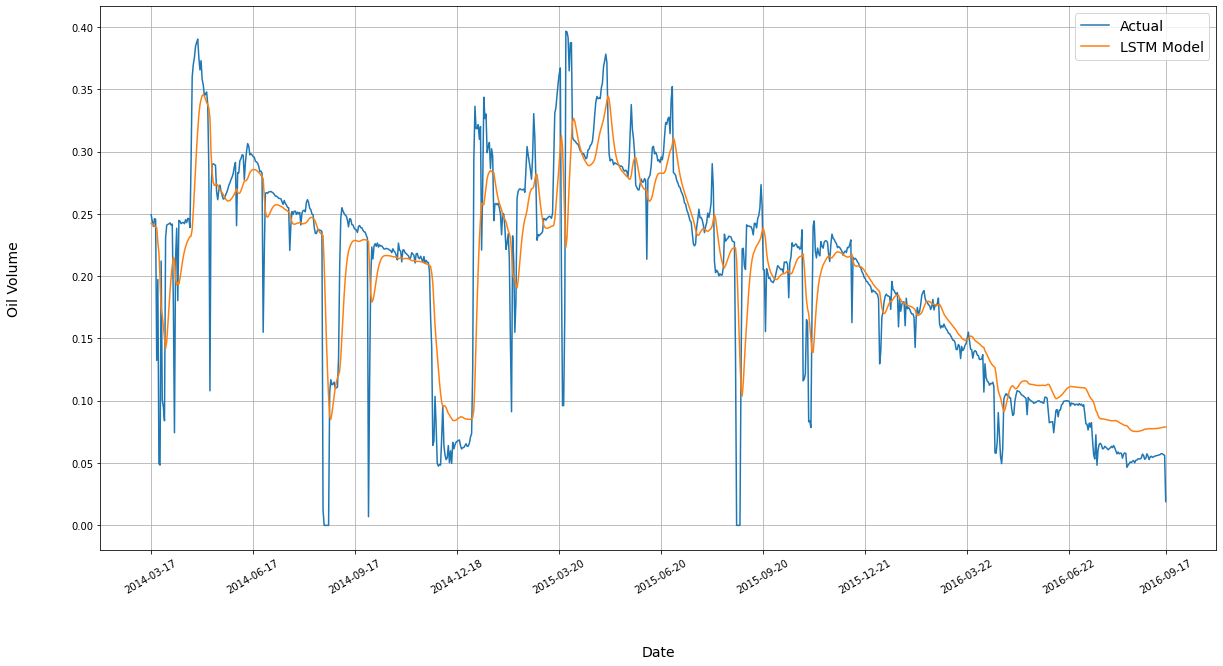

mae = 0.024986369535326958, 
mse = 0.00174854532815516, 
rmse = 0.041815611058014686
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 10)             480       
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 10)             840       
_________________________________________________________________
dense (Dense)                (1, None, 1)              11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'lstm/lstm_cell/kernel:0' shape=(1, 40) dtype=float32, numpy=
array([[ 0.12715334, -0.03530806, -0.11401649, -0.02173844, -0.33366272,
         0.15984134,  0.23008706,  0.30890104, -0.17613973, -0.21244234,
        -0.14184295,  0.18445289, -0.2899859 ,  0.03219714,  0.06786441,
    

In [11]:
#forecast
LSTM_oil_forecast = model.predict(scaled_oil_data[np.newaxis, :, np.newaxis])
LSTM_oil_forecast = LSTM_oil_forecast[0, split_date - 1:-1, 0]

plt.figure(figsize=(20, 10))

plot_series(date_valid, oil_valid, ylabel="Oil", label="Actual")
plot_series(date_valid, LSTM_oil_forecast, ylabel="Oil", label="LSTM Model")

plt.savefig(f'../plots/oil/oil_lstm_forecast.png')
plt.show()

mae = keras.metrics.mean_absolute_error(oil_valid, LSTM_oil_forecast).numpy()
mse = keras.metrics.mean_squared_error(oil_valid, LSTM_oil_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

model.summary()
print(model.trainable_variables)